In [1]:
import os, sys, glob, shutil
import argparse
import json
import yaml
import numpy as np
from pprint import pprint

import torch
import yaml
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from scipy.io import wavfile
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
%cd "D:\Schoolwork\TERM 3\WORK\visual_prosody"

D:\Schoolwork\TERM 3\WORK\visual_prosody


In [3]:
split_txt_val_path = r'.\preprocessed_data\Ego4D_final_v6\val.txt'
val_uids = []
with open(split_txt_val_path) as file:
    for line in file:
        # print(line.split('|')[0])
        val_uids.append(line.split('|')[0])

In [4]:
print(len(val_uids))

2772


In [5]:
from utils.model import get_model, get_vocoder, get_param_num, vocoder_infer
from utils.tools import to_device, log, synth_one_sample, expand, plot_mel
from model import FastSpeech2Loss
from dataset import Dataset
# from utils.auto_tqdm import tqdm
from evaluate import evaluate

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MCD

In [8]:
import os, sys, glob, shutil
import os.path as op
import argparse
import json
import yaml
import numpy as np
import pandas as pd
from pprint import pprint
import os.path as op

import torch
import torch.nn.functional as F
import torchaudio
import argparse
import fnmatch
import logging
import multiprocessing as mp
from typing import Dict, List, Tuple

import librosa
import pysptk
import pyworld as pw
import soundfile as sf
from fastdtw import fastdtw
from scipy import spatial

In [9]:
split_txt_val_path = r'.\preprocessed_data\Ego4D_final_v6\val.txt'
val_uids = []
with open(split_txt_val_path) as file:
    for line in file:
        # print(line.split('|')[0])
        val_uids.append(line.split('|')[0])

In [10]:
len(val_uids)

2772

In [11]:
recon_folder = r'.\output\0703a\result\Ego4D_final_v6\wav\reconstructed'
syn_folder = r'.\output\0703a\result\Ego4D_final_v6\wav\synthesized'
gt_folder = r'.\raw_data\Ego4D_final_v6\val\Ego4D_final_v6'

In [11]:
%%time

def sptk_extract(
    x: np.ndarray,
    fs: int,
    n_fft: int = 512,
    n_shift: int = 256,
    mcep_dim: int = 25,
    mcep_alpha: float = 0.41,
    is_padding: bool = False,
) -> np.ndarray:
    """Extract SPTK-based mel-cepstrum.

    Args:
        x (ndarray): 1D waveform array.
        fs (int): Sampling rate
        n_fft (int): FFT length in point (default=512).
        n_shift (int): Shift length in point (default=256).
        mcep_dim (int): Dimension of mel-cepstrum (default=25).
        mcep_alpha (float): All pass filter coefficient (default=0.41).
        is_padding (bool): Whether to pad the end of signal (default=False).

    Returns:
        ndarray: Mel-cepstrum with the size (N, n_fft).

    """
    # perform padding
    if is_padding:
        n_pad = n_fft - (len(x) - n_fft) % n_shift
        x = np.pad(x, (0, n_pad), "reflect")

    # get number of frames
    n_frame = (len(x) - n_fft) // n_shift + 1

    # get window function
    win = pysptk.sptk.hamming(n_fft)

    # check mcep and alpha
    if mcep_dim is None or mcep_alpha is None:
        mcep_dim, mcep_alpha = _get_best_mcep_params(fs)

    # calculate spectrogram
    mcep = [
        pysptk.mcep(
            x[n_shift * i : n_shift * i + n_fft] * win,
            mcep_dim,
            mcep_alpha,
            eps=1e-6,
            etype=1,
        )
        for i in range(n_frame)
    ]

    return np.stack(mcep)


def _get_best_mcep_params(fs: int) -> Tuple[int, float]:
    if fs == 16000:
        return 23, 0.42
    elif fs == 22050:
        return 34, 0.45
    elif fs == 24000:
        return 34, 0.46
    elif fs == 44100:
        return 39, 0.53
    elif fs == 48000:
        return 39, 0.55
    else:
        raise ValueError(f"Not found the setting for {fs}.")





uids = []
MCDs_recon = []
for uid in tqdm(val_uids):
    uids.append(uid)
    gen_x, gen_fs = sf.read(op.join(recon_folder, f"{uid}.wav"), dtype="int16")
    gt_x, gt_fs = sf.read(op.join(gt_folder, f"{uid}.wav"), dtype="int16")
    # print(gen_fs, gt_fs)
    fs = gen_fs
    if gen_fs != gt_fs:
        gt_x = librosa.resample(gt_x.astype(float), orig_sr=gt_fs, target_sr=gen_fs)

    # extract ground truth and converted features
    gen_mcep = sptk_extract(
        x=gen_x,
        fs=fs,
        n_fft=512,
        n_shift=256,
        mcep_dim=None,
        mcep_alpha=None,
    )
    gt_mcep = sptk_extract(
        x=gt_x,
        fs=fs,
        n_fft=512,
        n_shift=256,
        mcep_dim=None,
        mcep_alpha=None,
    )
    
    # DTW
    _, path = fastdtw(gen_mcep, gt_mcep, dist=spatial.distance.euclidean)
    twf = np.array(path).T
    gen_mcep_dtw = gen_mcep[twf[0]]
    gt_mcep_dtw = gt_mcep[twf[1]]

    # MCD
    diff2sum = np.sum((gen_mcep_dtw - gt_mcep_dtw) ** 2, 1)
    mcd = np.mean(10.0 / np.log(10.0) * np.sqrt(2 * diff2sum), 0)
    result = mcd
    MCDs_recon.append(result)

  0%|          | 0/2772 [00:00<?, ?it/s]

CPU times: total: 10min 44s
Wall time: 12min 53s


In [12]:
%%time

def sptk_extract(
    x: np.ndarray,
    fs: int,
    n_fft: int = 512,
    n_shift: int = 256,
    mcep_dim: int = 25,
    mcep_alpha: float = 0.41,
    is_padding: bool = False,
) -> np.ndarray:
    """Extract SPTK-based mel-cepstrum.

    Args:
        x (ndarray): 1D waveform array.
        fs (int): Sampling rate
        n_fft (int): FFT length in point (default=512).
        n_shift (int): Shift length in point (default=256).
        mcep_dim (int): Dimension of mel-cepstrum (default=25).
        mcep_alpha (float): All pass filter coefficient (default=0.41).
        is_padding (bool): Whether to pad the end of signal (default=False).

    Returns:
        ndarray: Mel-cepstrum with the size (N, n_fft).

    """
    # perform padding
    if is_padding:
        n_pad = n_fft - (len(x) - n_fft) % n_shift
        x = np.pad(x, (0, n_pad), "reflect")

    # get number of frames
    n_frame = (len(x) - n_fft) // n_shift + 1

    # get window function
    win = pysptk.sptk.hamming(n_fft)

    # check mcep and alpha
    if mcep_dim is None or mcep_alpha is None:
        mcep_dim, mcep_alpha = _get_best_mcep_params(fs)

    # calculate spectrogram
    mcep = [
        pysptk.mcep(
            x[n_shift * i : n_shift * i + n_fft] * win,
            mcep_dim,
            mcep_alpha,
            eps=1e-6,
            etype=1,
        )
        for i in range(n_frame)
    ]

    return np.stack(mcep)


def _get_best_mcep_params(fs: int) -> Tuple[int, float]:
    if fs == 16000:
        return 23, 0.42
    elif fs == 22050:
        return 34, 0.45
    elif fs == 24000:
        return 34, 0.46
    elif fs == 44100:
        return 39, 0.53
    elif fs == 48000:
        return 39, 0.55
    else:
        raise ValueError(f"Not found the setting for {fs}.")





uids = []
MCDs_gt = []
for uid in tqdm(val_uids):
    uids.append(uid)
    gen_x, gen_fs = sf.read(op.join(syn_folder, f"{uid}.wav"), dtype="int16")
    gt_x, gt_fs = sf.read(op.join(gt_folder, f"{uid}.wav"), dtype="int16")
    # print(gen_fs, gt_fs)
    fs = gen_fs
    if gen_fs != gt_fs:
        gt_x = librosa.resample(gt_x.astype(float), orig_sr=gt_fs, target_sr=gen_fs)

    # extract ground truth and converted features
    gen_mcep = sptk_extract(
        x=gen_x,
        fs=fs,
        n_fft=512,
        n_shift=256,
        mcep_dim=None,
        mcep_alpha=None,
    )
    gt_mcep = sptk_extract(
        x=gt_x,
        fs=fs,
        n_fft=512,
        n_shift=256,
        mcep_dim=None,
        mcep_alpha=None,
    )
    
    # DTW
    _, path = fastdtw(gen_mcep, gt_mcep, dist=spatial.distance.euclidean)
    twf = np.array(path).T
    gen_mcep_dtw = gen_mcep[twf[0]]
    gt_mcep_dtw = gt_mcep[twf[1]]

    # MCD
    diff2sum = np.sum((gen_mcep_dtw - gt_mcep_dtw) ** 2, 1)
    mcd = np.mean(10.0 / np.log(10.0) * np.sqrt(2 * diff2sum), 0)
    result = mcd
    MCDs_gt.append(result)

  0%|          | 0/2772 [00:00<?, ?it/s]

CPU times: total: 10min 52s
Wall time: 12min 32s


In [13]:
v6_mcd_df = pd.DataFrame({
    'uid': uids,
    'MCD_recon': MCDs_recon,
    'MCD_gt': MCDs_gt,
})

In [14]:
v6_mcd_df.to_csv(r".\jupyter_walkthrough\metrics\MCD_0703a_1M8_new.csv")

In [15]:
print(f"MCDs_recon mean on 0703a_1M8: {np.nanmean(MCDs_recon)}")
print(f"MCDs_recon std on 0703a_1M8: {np.nanstd(MCDs_recon)}")

print(f"MCDs_gt mean on 0703a_1M8: {np.nanmean(MCDs_gt)}")
print(f"MCDs_gt std on 0703a_1M8: {np.nanstd(MCDs_gt)}")

MCDs_recon mean on 0703a_1M8: 6.249993701012346
MCDs_recon std on 0703a_1M8: 1.993986635231096
MCDs_gt mean on 0703a_1M8: 9.622583061318892
MCDs_gt std on 0703a_1M8: 1.8739193166797672


In [17]:
v6_mcd_df.nsmallest(5, 'MCD_recon')

,uid,MCD_recon,MCD_gt
2129,4c848686-910e-41bd-b183-9a8867d236a9,3.014085,14.855412
455,f8208dae-c639-4da0-bdf0-c60e0423ddfa,3.174204,12.965023
1061,774fb2b7-15af-4028-bb0f-17725e2cfb7f,3.531757,8.687170
421,7db2ea64-468e-4944-89a7-1a88d4700ff3,3.672434,8.270328
1544,2a74df9f-b166-4818-93ef-dfeac40dfeb4,3.703487,8.366032


In [16]:
v6_mcd_df.nlargest(5, 'MCD_recon')

,uid,MCD_recon,MCD_gt
1464,c10644dc-4433-4cd7-af01-c05f979a3096,19.121027,21.446267
2681,e2c6f619-b8b6-46f4-b86d-41cec4d087cc,18.911029,31.372367
1943,3e9dea67-2372-4051-8356-76822d5edf3d,17.544246,17.073300
1372,980a66db-86cf-432f-8871-bfbf0684f805,17.450292,16.931053
1220,9082bee3-5303-455f-9cee-b890b7ee82e4,17.080437,17.699237


In [20]:
import matplotlib.pyplot as plt

In [21]:
v6_mcd_df['MCD_recon'].plot(kind='hist', bins=30)
plt.show()

C:\Users\Darre\AppData\Local\Temp\ipykernel_19056\4204294947.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [2]:
import pandas as pd

In [3]:
val_mcdv6_df = pd.read_csv(r".\jupyter_walkthrough\metrics\MCD_0703a_1M8_new.csv")


<Axes: ylabel='Frequency'>

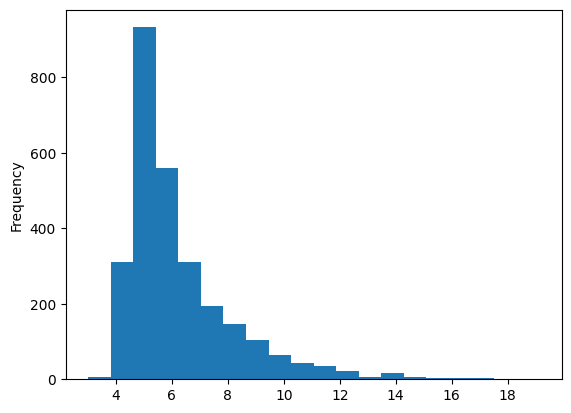

In [4]:
val_mcdv6_df['MCD_recon'].plot(kind='hist', bins=20)

# log f0

In [12]:
# https://github.com/espnet/espnet/blob/3e0dad524d62ccd45e067e9b36049f2214ea972a/egs2/TEMPLATE/asr1/pyscripts/utils/evaluate_f0.py

In [13]:
def world_extract(
    x: np.ndarray,
    fs: int,
    f0min: int = 40,
    f0max: int = 800,
    n_fft: int = 512,
    n_shift: int = 256,
    mcep_dim: int = 25,
    mcep_alpha: float = 0.41,
) -> np.ndarray:
    """Extract World-based acoustic features.

    Args:
        x (ndarray): 1D waveform array.
        fs (int): Minimum f0 value (default=40).
        f0 (int): Maximum f0 value (default=800).
        n_shift (int): Shift length in point (default=256).
        n_fft (int): FFT length in point (default=512).
        n_shift (int): Shift length in point (default=256).
        mcep_dim (int): Dimension of mel-cepstrum (default=25).
        mcep_alpha (float): All pass filter coefficient (default=0.41).

    Returns:
        ndarray: Mel-cepstrum with the size (N, n_fft).
        ndarray: F0 sequence (N,).

    """
    # extract features
    x = x.astype(np.float64)
    f0, time_axis = pw.harvest(
        x,
        fs,
        f0_floor=f0min,
        f0_ceil=f0max,
        frame_period=n_shift / fs * 1000,
    )
    sp = pw.cheaptrick(x, f0, time_axis, fs, fft_size=n_fft)
    if mcep_dim is None or mcep_alpha is None:
        mcep_dim, mcep_alpha = _get_best_mcep_params(fs)
    mcep = pysptk.sp2mc(sp, mcep_dim, mcep_alpha)

    return mcep, f0


def _get_basename(path: str) -> str:
    return os.path.splitext(os.path.split(path)[-1])[0]


def _get_best_mcep_params(fs: int) -> Tuple[int, float]:
    if fs == 16000:
        return 23, 0.42
    elif fs == 22050:
        return 34, 0.45
    elif fs == 24000:
        return 34, 0.46
    elif fs == 44100:
        return 39, 0.53
    elif fs == 48000:
        return 39, 0.55
    else:
        raise ValueError(f"Not found the setting for {fs}.")

In [14]:
uids = []
logf0_rmses_recon = []
logf0_corrs_recon = []

for uid in tqdm(val_uids):
    uids.append(uid)
    # load wav file as int16
    gen_x, gen_fs = sf.read(op.join(syn_folder, f"{uid}.wav"), dtype="int16")
    gt_x, gt_fs = sf.read(op.join(recon_folder, f"{uid}.wav"), dtype="int16")
    fs = gen_fs
    if gen_fs != gt_fs:
        gt_x = librosa.resample(gt_x.astype(float), orig_sr=gt_fs, target_sr=gen_fs)
    # extract ground truth and converted features
    gen_mcep, gen_f0 = world_extract(
        x=gen_x,
        fs=fs,
        f0min=40,
        f0max=800,
        n_fft=1024,
        n_shift=256,
        mcep_dim=None,
        mcep_alpha=None,
    )
    gt_mcep, gt_f0 = world_extract(
        x=gt_x,
        fs=fs,
        f0min=40,
        f0max=800,
        n_fft=1024,
        n_shift=256,
        mcep_dim=None,
        mcep_alpha=None,
    )
    
    # DTW
    _, path = fastdtw(gen_mcep, gt_mcep, dist=spatial.distance.euclidean)
    twf = np.array(path).T
    gen_f0_dtw = gen_f0[twf[0]]
    gt_f0_dtw = gt_f0[twf[1]]
    
    # Get voiced part
    nonzero_idxs = np.where((gen_f0_dtw != 0) & (gt_f0_dtw != 0))[0]
    gen_f0_dtw_voiced = np.log(gen_f0_dtw[nonzero_idxs])
    gt_f0_dtw_voiced = np.log(gt_f0_dtw[nonzero_idxs])

    # log F0 RMSE
    log_f0_rmse = np.sqrt(np.mean((gen_f0_dtw_voiced - gt_f0_dtw_voiced) ** 2))
    # print(f"{uid} {log_f0_rmse:.4f}")

    # log F0 corr
    log_f0_corr = np.corrcoef(gen_f0_dtw_voiced, gt_f0_dtw_voiced)[0][1]
    # print(f"{uid} {log_f0_corr:.4f}")

    logf0_rmses_recon.append(log_f0_rmse)
    logf0_corrs_recon.append(log_f0_corr)



  0%|          | 0/2772 [00:00<?, ?it/s]

D:\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
D:\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
D:\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
D:\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
D:\Programs\Python\Python311

In [15]:
uids = []
logf0_rmses_gt = []
logf0_corrs_gt = []

for uid in tqdm(val_uids):
    uids.append(uid)
    # load wav file as int16
    gen_x, gen_fs = sf.read(op.join(syn_folder, f"{uid}.wav"), dtype="int16")
    gt_x, gt_fs = sf.read(op.join(gt_folder, f"{uid}.wav"), dtype="int16")
    fs = gen_fs
    if gen_fs != gt_fs:
        gt_x = librosa.resample(gt_x.astype(float), orig_sr=gt_fs, target_sr=gen_fs)
    # extract ground truth and converted features
    gen_mcep, gen_f0 = world_extract(
        x=gen_x,
        fs=fs,
        f0min=40,
        f0max=800,
        n_fft=1024,
        n_shift=256,
        mcep_dim=None,
        mcep_alpha=None,
    )
    gt_mcep, gt_f0 = world_extract(
        x=gt_x,
        fs=fs,
        f0min=40,
        f0max=800,
        n_fft=1024,
        n_shift=256,
        mcep_dim=None,
        mcep_alpha=None,
    )
    
    # DTW
    _, path = fastdtw(gen_mcep, gt_mcep, dist=spatial.distance.euclidean)
    twf = np.array(path).T
    gen_f0_dtw = gen_f0[twf[0]]
    gt_f0_dtw = gt_f0[twf[1]]
    
    # Get voiced part
    nonzero_idxs = np.where((gen_f0_dtw != 0) & (gt_f0_dtw != 0))[0]
    gen_f0_dtw_voiced = np.log(gen_f0_dtw[nonzero_idxs])
    gt_f0_dtw_voiced = np.log(gt_f0_dtw[nonzero_idxs])

    # log F0 RMSE
    log_f0_rmse = np.sqrt(np.mean((gen_f0_dtw_voiced - gt_f0_dtw_voiced) ** 2))
    # print(f"{uid} {log_f0_rmse:.4f}")

    # log F0 corr
    log_f0_corr = np.corrcoef(gen_f0_dtw_voiced, gt_f0_dtw_voiced)[0][1]
    # print(f"{uid} {log_f0_corr:.4f}")

    logf0_rmses_gt.append(log_f0_rmse)
    logf0_corrs_gt.append(log_f0_corr)

  0%|          | 0/2772 [00:00<?, ?it/s]

D:\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [16]:
v6_logf0_df = pd.DataFrame({
    'uid': uids,
    'logf0_rmse_recon': logf0_rmses_recon,
    'logf0_corr_recon': logf0_corrs_recon,
    'logf0_rmse_gt': logf0_rmses_gt,
    'logf0_corr_gt': logf0_corrs_gt,
})
v6_logf0_df.to_csv(r".\jupyter_walkthrough\metrics\logF0_0703a_1M8_new.csv")

In [17]:
v6_logf0_df.shape

(2772, 5)

In [18]:
# v6_logf0_df = v6_logf0_df.dropna()

In [19]:
print(f"logf0_rmse_recon mean on 0703a_1M8: {np.nanmean(logf0_rmses_recon)}")
print(f"logf0_rmse_recon std on 0703a_1M8: {np.nanstd(logf0_rmses_recon)}")
print(f"logf0_corr_recon mean on 0703a_1M8: {np.nanmean(logf0_corrs_recon)}")
print(f"logf0_corr_recon std on 0703a_1M8: {np.nanstd(logf0_corrs_recon)}")

print(f"logf0_rmse_gt mean on LibriTTS: {np.nanmean(logf0_rmses_gt)}")
print(f"logf0_rmse_gt std on LibriTTS: {np.nanstd(logf0_rmses_gt)}")
print(f"logf0_corr_gt mean on 0703a_1M8: {np.nanmean(logf0_corrs_gt)}")
print(f"logf0_corr_gt std on 0703a_1M8: {np.nanstd(logf0_corrs_gt)}")

logf0_rmse_recon mean on 0703a_1M8: 0.2792688594598094
logf0_rmse_recon std on 0703a_1M8: 0.20945039763581058
logf0_corr_recon mean on 0703a_1M8: 0.4176989266265597
logf0_corr_recon std on 0703a_1M8: 0.38842276166476153
logf0_rmse_gt mean on LibriTTS: 0.3179804094211787
logf0_rmse_gt std on LibriTTS: 0.23774727609638105
logf0_corr_gt mean on 0703a_1M8: 0.33093707376307785
logf0_corr_gt std on 0703a_1M8: 0.40259407934929836
